In [1]:
import os
import os.path as osp
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from skimage.transform import resize
import pickle
from utils import process_coord, process_labels, process_samples, mask_pic

In [2]:
path = '../trainingData'

In [3]:
missing_names = [file for file in os.listdir(osp.join(path, 'missing'))]

present_names = [file for file in os.listdir(osp.join(path, 'present'))]

In [5]:
micells = []  # missing cells
for name in missing_names:
    with open(osp.join(path, 'missing', name), 'rb') as handle:
        micells.append(pickle.load(handle))

In [6]:
precells = []
for name in present_names:
    with open(osp.join(path, 'present', name), 'rb') as handle:
        precells.append(pickle.load(handle))

In [11]:
precells = [resize(cell, (50, 30, 3)) for cell in precells]
precells = np.array(precells)

In [12]:
micells = [resize(cell, (50, 30, 3)) for cell in micells]
micells = np.array(micells)

In [13]:
precells = precells[:micells.shape[0]]

In [14]:
cells = np.concatenate((micells, precells), axis=0)

In [15]:
milabels = np.zeros(micells.shape[0])
prelabels = np.ones(precells.shape[0])

In [16]:
labels = np.concatenate((milabels, prelabels), axis=0)

# Linear 

In [17]:
class Cells(Dataset):
    def __init__(self, cells, labels):
        self.cells = torch.from_numpy(cells)
        self.labels = torch.from_numpy(labels)
    def __len__(self):
        return self.cells.shape[0]
    def __getitem__(self, idx):
        return(self.cells[idx], self.labels[idx].type(torch.float))

In [18]:
cells_dataset = Cells(cells, labels)
train_data, test_data = random_split(cells_dataset, (round(0.8*len(cells_dataset)), round(0.2*len(cells_dataset))))
train_loader, test_loader = DataLoader(train_data, batch_size=400), DataLoader(test_data, batch_size=400)

In [64]:
class linNet(nn.Module):
    def __init__(self):
        super(linNet, self).__init__()
        self.lin1 = nn.Linear(3, 10)
        #self.lin2 = nn.Linear(10, 10)
        #self.lin3 = nn.Linear(10, 10)
        self.lin4 = nn.Linear(10, 1)
        self.sigm = nn.Sigmoid()
    def forward(self, x):
        x = self.sigm(self.lin1(x))
        #x = self.sigm(self.lin2(x))
        #x = self.sigm(self.lin3(x))
        x = self.sigm(self.lin4(x))
        return x

In [65]:
linmodel = linNet()

In [66]:
criterion = nn.BCELoss()
optimizer = optim.Adam(linmodel.parameters(), lr=0.1)

In [67]:
def training(train_loader):
    for data in train_loader:
        optimizer.zero_grad()
        cell, lab = data
        out = linmodel(cell)
        loss = criterion(out.mean(axis=(1, 2, 3)), lab)
        acc = (torch.round(out.mean(axis=(1, 2, 3))) == lab).sum()/out.shape[0]
        #print(f'Epoch: {epoch}, Loss: {loss:.3f}, Accuracy: {acc}')
        loss.backward()
        optimizer.step()

In [68]:
def testing(test_loader):
    for data in test_loader:
        cell, lab = data
        out = linmodel(cell)
        loss = criterion(out.mean(axis=(1, 2, 3)), lab)
        acc = (torch.round(out.mean(axis=(1, 2, 3))) == lab).sum()/out.shape[0]
        print(f'Epoch: {epoch}, Loss: {loss:.3f}, Accuracy: {acc}')

In [69]:
for epoch in range(201):
    training(train_loader)
    if epoch%10 == 0:
        print('Testing')
        testing(test_loader)
        print('Tesing is done')

Testing
Epoch: 0, Loss: 0.636, Accuracy: 0.6499999761581421
Epoch: 0, Loss: 0.657, Accuracy: 0.5975232124328613
Tesing is done
Testing
Epoch: 10, Loss: 0.543, Accuracy: 0.7400000095367432
Epoch: 10, Loss: 0.575, Accuracy: 0.6811145544052124
Tesing is done
Testing
Epoch: 20, Loss: 0.540, Accuracy: 0.7475000023841858
Epoch: 20, Loss: 0.570, Accuracy: 0.6965944170951843
Tesing is done
Testing
Epoch: 30, Loss: 0.534, Accuracy: 0.8149999976158142
Epoch: 30, Loss: 0.554, Accuracy: 0.7801857590675354
Tesing is done
Testing
Epoch: 40, Loss: 0.532, Accuracy: 0.8424999713897705
Epoch: 40, Loss: 0.549, Accuracy: 0.8080495595932007
Tesing is done
Testing
Epoch: 50, Loss: 0.531, Accuracy: 0.8475000262260437
Epoch: 50, Loss: 0.547, Accuracy: 0.8111454844474792
Tesing is done
Testing
Epoch: 60, Loss: 0.530, Accuracy: 0.8550000190734863
Epoch: 60, Loss: 0.546, Accuracy: 0.8111454844474792
Tesing is done
Testing
Epoch: 70, Loss: 0.530, Accuracy: 0.8550000190734863
Epoch: 70, Loss: 0.546, Accuracy: 0.81

In [70]:
idx = 5
print(list(train_loader)[idx][1][0])

linmodel(list(train_loader)[idx][0][0]).mean(axis=(0, 1))

tensor(1.)


tensor([0.6874], grad_fn=<MeanBackward1>)

In [71]:
torch.save(linmodel.state_dict(), 'linmodel')

# UNET

### Labels 

In [4]:
label_names = [file for file in os.listdir(osp.join(path, 'masks')) if file.endswith('.pickle')]
label_names.sort()

In [5]:
_labs = []
for name in label_names:
    with open(osp.join(path, 'masks', name), 'rb') as f:
        lab = pickle.load(f)
    _labs.append(lab)

In [6]:
labs = np.array(_labs)

### Features 

In [7]:
feature_names = [file for file in os.listdir(osp.join(path, 'crops')) if file.endswith('.pickle')]
feature_names.sort()

In [8]:
_feats = []
for name in feature_names:
    with open(osp.join(path, 'crops', name), 'rb') as f:
        lab = pickle.load(f)
    _feats.append(lab)

In [12]:
feats = np.array(_feats)

In [20]:
feats = feats/np.expand_dims(feats.max(axis=(1, 2)), (1, 2))  # normalize to 0...1 range

### Dataset, Dataloader 

In [21]:
class BlisterPacks(Dataset):
    def __init__(self, features, labels):
        self.features = torch.from_numpy(features)
        self.labels = torch.from_numpy(labels)
        
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self, idx):
        return (self.features[idx].transpose(0, -1), self.labels[idx].transpose(0, -1))  # unsqueeze for the number of channels

In [22]:
blister_packs = BlisterPacks(feats, labs)
train_data, test_data = random_split(blister_packs, (round(0.8*len(blister_packs)), round(0.2*len(blister_packs))))
train_loader, test_loader = DataLoader(train_data), DataLoader(test_data)

### Unet

In [23]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        kernel_size = 3
        self.conv1 = nn.Conv2d(3, 64, kernel_size)
        self.conv2 = nn.Conv2d(64, 64, kernel_size)
        self.maxpool1 = nn.MaxPool2d(2, return_indices=True)

        self.conv3 = nn.Conv2d(64,128, kernel_size)
        self.conv4 = nn.Conv2d(128, 128, kernel_size)
        self.maxpool2 = nn.MaxPool2d(2, return_indices=True)

        self.conv5 = nn.Conv2d(128,256, kernel_size)
        self.conv6 = nn.Conv2d(256, 256, kernel_size)
        self.maxpool3 = nn.MaxPool2d(2, return_indices=True)

        self.conv7 = nn.Conv2d(256,512, kernel_size)
        self.conv8 = nn.Conv2d(512, 512, kernel_size)
        self.maxpool4 = nn.MaxPool2d(2, return_indices=True)

        self.conv9 = nn.Conv2d(512, 1024, kernel_size)
        self.convt1 = nn.ConvTranspose2d(1024, 512, kernel_size)
        self.maxunpool1 = nn.MaxUnpool2d(2)

        # Paper suggests using conv in tandem with convTranspose. I use only convsTranspose, because then the dims match.
        # May be wrong
        self.convt2 = nn.ConvTranspose2d(1024, 512, kernel_size)
        self.convt3 = nn.ConvTranspose2d(512, 256, kernel_size)
        self.maxunpool2 = nn.MaxUnpool2d(2)

        self.convt4 = nn.ConvTranspose2d(512, 256, kernel_size)
        self.convt5 = nn.ConvTranspose2d(256, 128, kernel_size)
        self.maxunpool3 = nn.MaxUnpool2d(2)

        self.convt6 = nn.ConvTranspose2d(256, 128, kernel_size)
        self.convt7 = nn.ConvTranspose2d(128, 64, kernel_size)
        self.maxunpool4 = nn.MaxUnpool2d(2)

        self.convt8 = nn.ConvTranspose2d(128, 64, kernel_size)
        self.convt9 = nn.ConvTranspose2d(64, 64, kernel_size)
        
        self.conv10 = nn.Conv2d(64, 3, kernel_size = 1)
        self.relu = nn.ReLU()
        
        # Weight initialization
        nn.init.normal_(self.conv1.weight, std=(2/(1*kernel_size*kernel_size))**(1/2))
        nn.init.normal_(self.conv2.weight, std=(2/(64*kernel_size*kernel_size))**(1/2))
        
        nn.init.normal_(self.conv3.weight, std=(2/(64*kernel_size*kernel_size))**(1/2))
        nn.init.normal_(self.conv4.weight, std=(2/(128*kernel_size*kernel_size))**(1/2))
        
        nn.init.normal_(self.conv5.weight, std=(2/(128*kernel_size*kernel_size))**(1/2))
        nn.init.normal_(self.conv6.weight, std=(2/(256*kernel_size*kernel_size))**(1/2))
        
        nn.init.normal_(self.conv7.weight, std=(2/(256*kernel_size*kernel_size))**(1/2))
        nn.init.normal_(self.conv8.weight, std=(2/(512*kernel_size*kernel_size))**(1/2))
        
        nn.init.normal_(self.conv9.weight, std=(2/(512*kernel_size*kernel_size))**(1/2))
        nn.init.normal_(self.convt1.weight, std=(2/(1024*kernel_size*kernel_size))**(1/2))
        
        nn.init.normal_(self.convt2.weight, std=(2/(1024*kernel_size*kernel_size))**(1/2))
        nn.init.normal_(self.convt3.weight, std=(2/(512*kernel_size*kernel_size))**(1/2))
        
        nn.init.normal_(self.convt4.weight, std=(2/(512*kernel_size*kernel_size))**(1/2))
        nn.init.normal_(self.convt5.weight, std=(2/(256*kernel_size*kernel_size))**(1/2))
        
        nn.init.normal_(self.convt6.weight, std=(2/(256*kernel_size*kernel_size))**(1/2))
        nn.init.normal_(self.convt7.weight, std=(2/(128*kernel_size*kernel_size))**(1/2))

        nn.init.normal_(self.convt8.weight, std=(2/(128*kernel_size*kernel_size))**(1/2))
        nn.init.normal_(self.convt9.weight, std=(2/(64*kernel_size*kernel_size))**(1/2))
        
        nn.init.normal_(self.conv10.weight, std=(2/(64*1*1))**(1/2))
        
    def forward(self, x):
        # Contracting path
        x1 = self.relu(self.conv1(x))  # (64, 255, 255)
        x2 = self.relu(self.conv2(x1))  # (64, 253, 253)
        x3, idcs1 = self.maxpool1(x2)  # (64, 126, 126)

        x4 = self.relu(self.conv3(x3))  # (128, 124, 124)
        x5 = self.relu(self.conv4(x4))# (128, 122, 122)
        x6, idcs2 = self.maxpool2(x5)  # (128, 61, 61)

        x7 = self.relu(self.conv5(x6))# (256, 59, 59)
        x8 = self.relu(self.conv6(x7))# (256, 57, 57)
        x9, idcs3 = self.maxpool3(x8)  # (256, 28, 28)

        x10 = self.relu(self.conv7(x9)) # (512, 26, 26)
        x11 = self.relu(self.conv8(x10)) # (512, 24, 24)
        x12, idcs4 = self.maxpool4(x11)  # (512, 12, 12)

        x13 = self.relu(self.conv9(x12)) # (1024, 10, 10)
        x14 = self.relu(self.convt1(x13))  # Up-conv  (512, 12, 12)
        # Expansive path
        x15 = self.maxunpool1(x14, indices=idcs4)  # Upsample feature map  (512, 24, 24)
        # Drop a row to match the dims (Recently added. Change?)
        x11 = x11[:, :, :x15.shape[2]]  
        x15 = torch.cat((x11, x15), dim=1)  # Concatenate. Note, resulting variable has the same name (1024, 24, 24)

        x16 = self.relu(self.convt2(x15))  # (512, 26, 26)
        x17 = self.convt3(x16)  # (512, 28, 28)
        #print(x17.shape, x8.shape, sep='\n')
        x18 = self.maxunpool2(x17, indices=idcs3, output_size=x8.shape[-2:])  # (512, 57, 57)  Actually 256 channels
        x18 = torch.cat((x8, x18), dim=1)  # (512, 57, 57)

        x19 = self.relu(self.convt4(x18))  # (256, 59, 59)
        x20 = self.relu(self.convt5(x19))  # (128, 61, 61)
        x21 = self.maxunpool3(x20, indices=idcs2, output_size=x5.shape[-2:])  # (128, 122, 122)
        x21 = torch.cat((x5, x21), dim=1)  # (256, 122, 122)

        x22 = self.convt6(x21)  # (128, 124, 124)
        x23 = self.convt7(x22)  # (64, 126, 126)
        x24 = self.maxunpool4(x23, indices=idcs1, output_size=x2.shape[-2:])  # (64, 253, 253)
        x24 = torch.cat((x2, x24), dim=1)  # (128, 253, 253)

        x25 = self.relu(self.convt8(x24))  # (64, 255, 255)
        x26 = self.relu(self.convt9(x25))  # (64, 257, 257)
        
        out = self.conv10(x26)  # (1, 257, 257)
        
        return out

convmodel = Unet()

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convmodel.parameters(), lr=0.01)

In [25]:
def training(data_loader):
    for i, data in enumerate(data_loader):
        feats, labs = data
        out = convmodel(feats)
        optimizer.zero_grad()
        loss = criterion(out, labs)
        print(f'[{i}/{len(data_loader)}] Loss: {loss:.5f} out.sum(): {out.sum():.3f} out.unique().size(): {out.unique().size()}')
        if i%10 == 0:
            plt.imshow(out[0, 0].detach().numpy())
            plt.show()
        loss.backward()
        optimizer.step()
    return loss, out

/home/ross/comprns/lib/python3.8/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


[0/1227] Loss: 1.57005 out.sum(): -122614.047 out.unique().size(): torch.Size([197621])


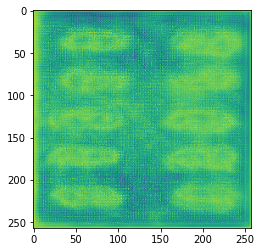

[1/1227] Loss: 3866859008.00000 out.sum(): -3943803387904.000 out.unique().size(): torch.Size([198041])
[2/1227] Loss: 147.41618 out.sum(): 2481704.000 out.unique().size(): torch.Size([198006])
[3/1227] Loss: 6542.39795 out.sum(): 137527584.000 out.unique().size(): torch.Size([197995])
[4/1227] Loss: 794.09906 out.sum(): 16927872.000 out.unique().size(): torch.Size([197779])
[5/1227] Loss: 1652.65735 out.sum(): 33965768.000 out.unique().size(): torch.Size([197912])
[6/1227] Loss: 95.23505 out.sum(): 2173627.500 out.unique().size(): torch.Size([197908])
[7/1227] Loss: 1051.47998 out.sum(): 22080228.000 out.unique().size(): torch.Size([197724])
[8/1227] Loss: 1827.24023 out.sum(): 42131784.000 out.unique().size(): torch.Size([197707])
[9/1227] Loss: 1131.99768 out.sum(): 29971820.000 out.unique().size(): torch.Size([197679])
[10/1227] Loss: 11397.80566 out.sum(): 352438080.000 out.unique().size(): torch.Size([197607])


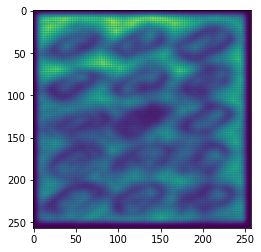

[11/1227] Loss: 2162.20508 out.sum(): 65623168.000 out.unique().size(): torch.Size([197580])
[12/1227] Loss: 4381.82910 out.sum(): 137417376.000 out.unique().size(): torch.Size([197640])
[13/1227] Loss: 4986.46777 out.sum(): 165687296.000 out.unique().size(): torch.Size([197601])
[14/1227] Loss: 4831.72217 out.sum(): 153126672.000 out.unique().size(): torch.Size([197715])
[15/1227] Loss: 3713.19141 out.sum(): 125926624.000 out.unique().size(): torch.Size([197614])
[16/1227] Loss: 1075.47839 out.sum(): 39845148.000 out.unique().size(): torch.Size([197607])
[17/1227] Loss: 775.20331 out.sum(): 27919524.000 out.unique().size(): torch.Size([197885])
[18/1227] Loss: 1495.14868 out.sum(): 54546704.000 out.unique().size(): torch.Size([195816])
[19/1227] Loss: 2218.48682 out.sum(): 80905600.000 out.unique().size(): torch.Size([195396])
[20/1227] Loss: 2128.60669 out.sum(): 84723808.000 out.unique().size(): torch.Size([194453])


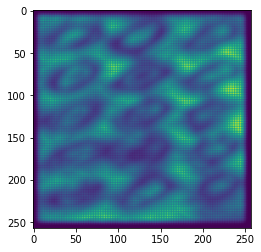

[21/1227] Loss: 1197.15405 out.sum(): 45022536.000 out.unique().size(): torch.Size([193783])
[22/1227] Loss: 616.39618 out.sum(): 24319152.000 out.unique().size(): torch.Size([191825])
[23/1227] Loss: 56.75956 out.sum(): 2333983.250 out.unique().size(): torch.Size([182548])
[24/1227] Loss: 153.93642 out.sum(): 5098900.000 out.unique().size(): torch.Size([189151])
[25/1227] Loss: 122.98668 out.sum(): 3947908.000 out.unique().size(): torch.Size([188386])
[26/1227] Loss: 67.75011 out.sum(): 2750932.750 out.unique().size(): torch.Size([181039])
[27/1227] Loss: 290.64133 out.sum(): 11733490.000 out.unique().size(): torch.Size([188641])
[28/1227] Loss: 347.12152 out.sum(): 14797940.000 out.unique().size(): torch.Size([187485])
[29/1227] Loss: 263.57721 out.sum(): 10627561.000 out.unique().size(): torch.Size([186893])
[30/1227] Loss: 52.39854 out.sum(): 2179039.750 out.unique().size(): torch.Size([180769])


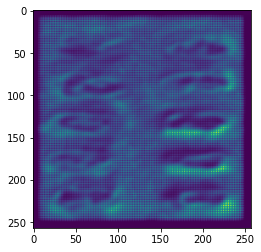

[31/1227] Loss: 1.59233 out.sum(): 10366.307 out.unique().size(): torch.Size([27527])
[32/1227] Loss: 666.15088 out.sum(): 23604416.000 out.unique().size(): torch.Size([191179])
[33/1227] Loss: 1.58908 out.sum(): 8462.210 out.unique().size(): torch.Size([2799])
[34/1227] Loss: 23.50164 out.sum(): 974351.625 out.unique().size(): torch.Size([178269])
[35/1227] Loss: 67.97096 out.sum(): 2706881.000 out.unique().size(): torch.Size([182227])
[36/1227] Loss: 91.05019 out.sum(): 3678557.000 out.unique().size(): torch.Size([184951])
[37/1227] Loss: 73.52946 out.sum(): 3029317.500 out.unique().size(): torch.Size([182674])
[38/1227] Loss: 31.30716 out.sum(): 1413895.625 out.unique().size(): torch.Size([173726])
[39/1227] Loss: 8.08282 out.sum(): 322970.906 out.unique().size(): torch.Size([101814])
[40/1227] Loss: 4.21886 out.sum(): 107770.859 out.unique().size(): torch.Size([29012])


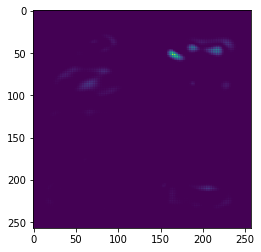

[41/1227] Loss: 25.72699 out.sum(): 933673.875 out.unique().size(): torch.Size([81016])
[42/1227] Loss: 23.19337 out.sum(): 808038.375 out.unique().size(): torch.Size([77258])
[43/1227] Loss: 1.85187 out.sum(): 20238.518 out.unique().size(): torch.Size([25502])
[44/1227] Loss: 64.82941 out.sum(): 2708982.500 out.unique().size(): torch.Size([181688])
[45/1227] Loss: 20.44660 out.sum(): 869390.750 out.unique().size(): torch.Size([177357])
[46/1227] Loss: 5.32290 out.sum(): 189406.594 out.unique().size(): torch.Size([139599])
[47/1227] Loss: 1.61927 out.sum(): 9637.826 out.unique().size(): torch.Size([18775])
[48/1227] Loss: 1.77596 out.sum(): 12694.386 out.unique().size(): torch.Size([6138])
[49/1227] Loss: 516.31384 out.sum(): 18970788.000 out.unique().size(): torch.Size([25917])
[50/1227] Loss: 2.29338 out.sum(): 39191.477 out.unique().size(): torch.Size([25852])


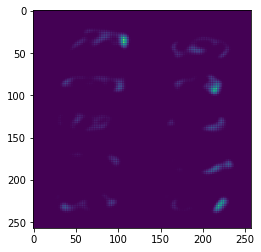

[51/1227] Loss: 8.48986 out.sum(): 310126.344 out.unique().size(): torch.Size([97545])
[52/1227] Loss: 41.30492 out.sum(): 1642186.750 out.unique().size(): torch.Size([173309])
[53/1227] Loss: 80.54212 out.sum(): 3186841.000 out.unique().size(): torch.Size([178405])
[54/1227] Loss: 56.72010 out.sum(): 2218411.000 out.unique().size(): torch.Size([178229])
[55/1227] Loss: 13.87243 out.sum(): 554675.188 out.unique().size(): torch.Size([143592])
[56/1227] Loss: 1074.29004 out.sum(): 37005576.000 out.unique().size(): torch.Size([51256])
[57/1227] Loss: 4.25696 out.sum(): 99742.922 out.unique().size(): torch.Size([41278])
[58/1227] Loss: 224.78893 out.sum(): 8703534.000 out.unique().size(): torch.Size([167321])
[59/1227] Loss: 463.68857 out.sum(): 17862458.000 out.unique().size(): torch.Size([185380])
[60/1227] Loss: 659.99988 out.sum(): 27501608.000 out.unique().size(): torch.Size([187992])


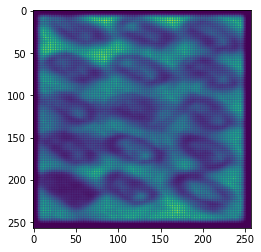

[61/1227] Loss: 177.48360 out.sum(): 6875200.000 out.unique().size(): torch.Size([183132])
[62/1227] Loss: 89.12144 out.sum(): 3079172.500 out.unique().size(): torch.Size([158607])
[63/1227] Loss: 1.52504 out.sum(): 6595.714 out.unique().size(): torch.Size([1689])
[64/1227] Loss: 4.05182 out.sum(): 131771.172 out.unique().size(): torch.Size([99038])
[65/1227] Loss: 37.13321 out.sum(): 1515015.500 out.unique().size(): torch.Size([177599])
[66/1227] Loss: 15.22018 out.sum(): 620275.062 out.unique().size(): torch.Size([174516])
[67/1227] Loss: 1.70077 out.sum(): 12478.755 out.unique().size(): torch.Size([21249])
[68/1227] Loss: 3.99977 out.sum(): 80220.516 out.unique().size(): torch.Size([62431])
[69/1227] Loss: 101.96163 out.sum(): 3580770.000 out.unique().size(): torch.Size([177470])
[70/1227] Loss: 490.60229 out.sum(): 19277236.000 out.unique().size(): torch.Size([184429])


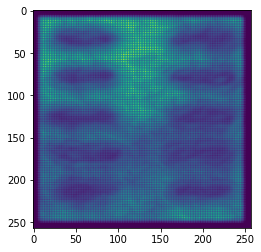

[71/1227] Loss: 865.55615 out.sum(): 35235932.000 out.unique().size(): torch.Size([188415])
[72/1227] Loss: 370.08032 out.sum(): 15365164.000 out.unique().size(): torch.Size([185026])
[73/1227] Loss: 1.61832 out.sum(): 9550.311 out.unique().size(): torch.Size([22685])
[74/1227] Loss: 1349.83862 out.sum(): 47561136.000 out.unique().size(): torch.Size([188166])
[75/1227] Loss: 80.15248 out.sum(): 3199091.000 out.unique().size(): torch.Size([180858])
[76/1227] Loss: 598.97290 out.sum(): 24076564.000 out.unique().size(): torch.Size([188055])
[77/1227] Loss: 1041.57532 out.sum(): 41960840.000 out.unique().size(): torch.Size([187375])
[78/1227] Loss: 791.60480 out.sum(): 33207932.000 out.unique().size(): torch.Size([187869])
[79/1227] Loss: 472.50085 out.sum(): 18817820.000 out.unique().size(): torch.Size([184400])


In [ ]:
for epoch in range(1):
    training(train_loader)
#     for data in train_loader:
#         feats, labs = data
#         out = convmodel(feats)
#         optimizer.zero_grad()
#         loss = criterion(out, labs)
#         print(f'[{i}/{len(data_loader)}] Loss: {loss:.5f} out.sum(): {out.sum():.3f} out.unique().size(): {out.unique().size()}')
#         loss.backward()

### Visualization 

In [ ]:
plt.imshow(samples[2], origin='lower')

In [ ]:
plt.imshow(masks[2], origin='lower')